<a href="https://colab.research.google.com/github/dtabuena/Images/blob/main/Nell2/Nell2_CA3_Optimize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install python-bioformats
import javabridge
import bioformats
javabridge.start_vm(class_path=bioformats.JARS)

####
from IPython.display import clear_output

import numpy as np
import pandas as pd
import skimage
from skimage import filters
from matplotlib import pyplot as plt
import matplotlib
import os
import scipy
from scipy import ndimage as ndi
import os
import tifffile
from tqdm import tqdm
from google.colab import files

os.environ["CELLPOSE_LOCAL_MODELS_PATH"] = "/PATH_FOR_MODELS/"

!pip install cellpose
from cellpose import models
clear_output()

In [2]:
def get_drobox_folder(link, new_filename):
    'Download a folder from dropbox and unzip'
    zipped_file_path = "/content/"+new_filename + ".zip"
    unzipped_file_path = "/content/"+new_filename
    if not( os.path.exists(zipped_file_path)):
        !wget -O $zipped_file_path $link    # download with new name
    !echo A | unzip $zipped_file_path -d $unzipped_file_path 
    return new_filename

def get_sub_files(rootdir):
    'Recursively search subfolders and return a list of all files'
    file_list =[]
    for rootdir, dirs, files in os.walk(rootdir): 
            file_list.extend([os.path.join(rootdir,f) for f in files])
    return file_list



def read_image(image_name):
    my_reader = bioformats.get_image_reader('my_image', image_name)

    c_dim = my_reader.rdr.getSizeC()
    z_dim = my_reader.rdr.getSizeZ()
    x_dim = my_reader.rdr.getSizeX()
    y_dim = my_reader.rdr.getSizeY()
    # print(x_dim,y_dim,c_dim,z_dim)

    image = np.empty([x_dim,y_dim,c_dim,z_dim])
    for zi in range(z_dim):
        img_zi = my_reader.read(c=None, z=zi,rescale=True)
        image[:,:,:,zi] = img_zi

    for ci in range(image.shape[2]):
        cim = image[:,:,ci,:]
        flat = cim.flatten()
        max= np.percentile(flat,100)
        assert max>0 , print(flat)
        cim = cim/max
        image[:,:,ci,:] = cim
    return image


def norm_channels(image,chan_dim,z_dim,):
    '''Transpose ndims, preserve labels'''
    dim_order = np.arange(image.ndim).tolist()
    dim_order = [chan_dim, z_dim] + [d for d in dim_order if d not in [chan_dim, z_dim]]
    chan_dim = [i for i in range(len(dim_order)) if dim_order[i]==chan_dim][0]
    z_dim = [i for i in range(len(dim_order)) if dim_order[i]==z_dim][0]

    '''Normalize channel intensities'''
    image_r=np.transpose(image.copy(),dim_order)
    ch_val_list = []
    for ch in range(image_r.shape[chan_dim]):    
        ch_val = image_r[ch,:,:,:].copy()
        for zi in range(image_r.shape[z_dim]):
            ch_val_z = ch_val[zi,:,:]
            ch_val_z = (ch_val_z-np.mean(ch_val_z.flatten())) / np.std(ch_val_z.flatten()) # zscore
            ch_val_z = (ch_val_z) / np.std(ch_val_z.flatten())
            ch_val[zi,:,:] = ch_val_z
        ch_val_list.append(ch_val)
    image_znorm = np.stack(ch_val_list,axis=0)
    return image_znorm, image_r,chan_dim,z_dim


def mask_image_cellpose(image_r,cell_chan,diameter,exp_dist):
    '''Generate Masks with Cellpose'''
    model = models.Cellpose(model_type='cyto')
    masks, _, _, _ = model.eval(image_r[cell_chan,:,:,:], diameter=diameter, channels=[0,0], stitch_threshold=.001,do_3D=False)
    masks=masks.astype(float)
    exp_masks = masks.copy()
    for zi in range(masks.shape[0]):
        exp_masks[zi,:,:] = skimage.segmentation.expand_labels(exp_masks[zi,:,:], distance=exp_dist)
    return exp_masks, exp_masks



def quant_cells(image_znorm, image_r, exp_masks,chan_dim):
    '''Quantify Cell Intensities'''
    cell_ids =np.arange(0,np.nanmax(exp_masks.flatten()))+1
    cell_df = pd.DataFrame({'cell_id':cell_ids}).set_index('cell_id')
    for ch in range(image_znorm.shape[chan_dim]):
        for cell in cell_df.index:
            if ch==0:
                cell_df.at[cell,'size'] = np.nansum((exp_masks.flatten()==cell))
                cell_df.at[cell,'cross_area'] = np.nansum( np.max( exp_masks==cell,axis=0).flatten())
                cell_coord = np.where(exp_masks==cell)
                image_size = exp_masks.shape
                dim_check =[]
                for di in range(len(cell_coord)):
                    dim_check.append(0 == min(cell_coord[di]))
                    dim_check.append(np.max(cell_coord[di]) == image_size[di])
                cell_df.at[cell,'is_edge'] = any(dim_check)

            cell_df.at[cell,'mean_'+ch_names[ch]] = np.nansum( image_znorm[ch,:,:,:][exp_masks==cell]) / cell_df.loc[cell,'size']
            cell_df.at[cell,'raw_mean_'+ch_names[ch]] = np.nansum( image_r[ch,:,:,:][exp_masks==cell]) / cell_df.loc[cell,'size']
            


    return cell_df


def calc_odd(cell_df,t):
    '''Calculate Odds Ratios'''
    is_green = cell_df['mean_target']>t
    not_green = cell_df['mean_target']<=t
    is_red = cell_df['mean_mCherry']>t
    not_red = cell_df['mean_mCherry']<=t

    p_G_nR = np.mean(  is_green[not_red]  )
    p_G_iR = np.mean(  is_green[is_red]  )
    # print('P(G|~R)',p_G_nR)
    # print('P(G|R)',p_G_iR)

    p_R_iG = np.mean(  is_red[is_green]  )
    p_R_nG = np.mean(  is_red[not_green]  )
    # print('P(R|G)',p_R_iG)
    # print('P(R|~G)',p_R_nG)

    num_RnG = np.sum(is_red[not_green] )
    num_nRnG = np.sum(not_red[not_green] )
    num_RG = np.sum(is_red[is_green] )
    num_nRG = np.sum(not_red[is_green] )
    OR = (num_RG * num_nRnG)/ (num_RnG * num_nRG)
    # print('odds',OR)

    targ_sig_nR = np.mean(cell_df['raw_mean_target'][cell_df['mean_mCherry']<t])
    targ_sig_iR = np.mean(cell_df['raw_mean_target'][cell_df['mean_mCherry']>t])

    results = {'OR':OR,
               'num_RnG':num_RnG,
               'num_nRnG':num_nRnG,
               'num_RG':num_RG,
               'num_nRG':num_nRG,
               'targ_sig_nR':targ_sig_nR,
               'targ_sig_iR':targ_sig_iR}

    cell_df['Pos']=cell_df['mean_mCherry']>t
    mean_target_negative = np.mean(cell_df['raw_mean_target'][np.logical_not(cell_df['Pos'].values)])
    mean_target_negative=1
    cell_df['target_norm'] = cell_df['raw_mean_target'] / mean_target_negative
    cell_df['target_norm_NEG'] = cell_df['target_norm'][np.logical_not(cell_df['Pos'].values)]
    cell_df['target_norm_POS'] = cell_df['target_norm'][cell_df['Pos']]

    cell_df['cross_area_NEG'] = cell_df['cross_area'][np.logical_not(cell_df['Pos'].values)]
    cell_df['cross_area_POS'] = cell_df['cross_area'][cell_df['Pos']]

    results=pd.DataFrame(data=results,index=[0])


    return results, cell_df



def plot_sample(fov,inset_xy=None,pxl_per_um=800/159.1,title=None,zi=0,mask=None,min=0,max=4,zmax=False):
    sb_x = 195
    sb_y = 4
    sb_x = 780
    sb_y = 10

    plot_norm = fov['image_znorm'].copy()

    if zmax:
        plot_norm[:,0,:,:] = np.nanmax(plot_norm,axis=1)
        if mask is not None: mask[0,:,:] = np.max(mask,axis=0)
        zi=0

    for ch in range(plot_norm.shape[0]):
        plot_norm[ch,:,:,:] = (np.clip(plot_norm[ch,:,:,:],min,max)-min)/(max-min)
        # plt.hist(plot_norm.flatten(),np.arange(min,max,.1))



    image_name= fov['image_name']
    image_name= os.path.basename(fov['image_name']).split('.')[0]
    potential_targets = ['MDGA2','Nell2','RNF182']
    target_name = [t for t in potential_targets if t in image_name][0]
    # print(target_name)

    if inset_xy is not None: fig_sample, axs = plt.subplots(2,4,figsize=(20,10))
    else: fig_sample, axs = plt.subplots(1,4,figsize=(20,5))
    
    axs=axs.flatten()
    axs[0].imshow(plot_norm[2,zi,:,:],cmap='gray') # ,vmax=1.5
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black","red"])
    axs[1].imshow(plot_norm[1,zi,:,:],cmap=cmap) # ,vmax=1.5
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black","green"])
    axs[2].imshow(plot_norm[0,zi,:,:],cmap=cmap) # ,vmax=1.5


    w_sig = plot_norm[2,zi,:,:]
    # w_sig = w_sig+np.percentile(w_sig.flatten(),.1)
    # w_sig = w_sig/np.percentile(w_sig.flatten(),99.9)
    w_chan = np.stack( [w_sig for i in range(3)] ,axis=-1)
    r_sig = plot_norm[1,zi,:,:]
    # r_sig = r_sig+np.percentile(r_sig.flatten(),.0)
    # r_sig = r_sig/np.percentile(r_sig.flatten(),100)
    r_chan = np.stack( [r_sig, np.zeros_like(r_sig), np.zeros_like(r_sig)],axis=-1)
    g_sig = plot_norm[0,zi,:,:]
    # g_sig = g_sig-(np.percentile(g_sig.flatten(),0)*2)
    # g_sig = g_sig/(np.percentile(g_sig.flatten(),100)*1)
    g_chan = np.stack( [ np.zeros_like(g_sig), g_sig, np.zeros_like(g_sig)],axis=-1)
    merge = w_chan*0.3 + r_chan + g_chan*0.5
    axs[3].imshow(merge)


    axs[0].text(10,790,'NeuN',color='w',fontsize=24)
    axs[1].text(10,790,'mCherry',color=[1,0,0,1],fontsize=24)
    axs[2].text(10,790,target_name,color=[0,1,0,1],fontsize=24)
    # axs[3].text(0,800,'NeuN',color='w')

    pxl_per_um = 800/160
    sb_x = merge.shape[1]*.975
    sb_y = merge.shape[0]*.025
    big_scale_bar = matplotlib.patches.Rectangle([sb_x,sb_y],   -25*pxl_per_um , 10, alpha=1, facecolor='w',edgecolor='w',linewidth=0)
    axs[0].add_patch(big_scale_bar)

    if inset_xy is not None:
        y1,y2,x1,x2, = inset_xy
        my_rect = matplotlib.patches.Rectangle([y1,x1],  y2-y1, x2-x1,alpha=1, facecolor='none',edgecolor='c',linewidth=3)
        axs[0].add_patch(my_rect)

        # fig, axs = plt.subplots(1,4,figsize=(32,8))
        # axs=axs.flatten()
        axs[4].imshow(plot_norm[2,zi,x1:x2,y1:y2],cmap='gray',vmax=1)
        cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black","red"])
        axs[5].imshow(plot_norm[1,zi,x1:x2,y1:y2],cmap=cmap, vmax=1)
        cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black","green"])
        axs[6].imshow(plot_norm[0,zi,x1:x2,y1:y2],cmap=cmap,vmax=1)
        axs[7].imshow(merge[x1:x2,y1:y2,:])

        sb_x = (x2-x1)*.975
        sb_y = (y2-y1)*.025
        small_scale_bar = matplotlib.patches.Rectangle([sb_x,sb_y],   -5*pxl_per_um , 3, alpha=1, facecolor='w',edgecolor='w',linewidth=0)
        axs[4].add_patch(small_scale_bar)


    for a in axs:
            a.get_xaxis().set_visible(False)
            a.get_yaxis().set_visible(False)
        
    if mask is not None:
        mask_bin = mask[zi,:,:]>0
        edge_bin = skimage.filters.sobel(mask[zi,:,:])>0
        print(edge_bin.shape)
        for a in axs[:4]:
            a.contour(edge_bin)
        for a in axs[4:]:
            a.contour(edge_bin[x1:x2,y1:y2])

    if title is not None:
        fig_sample.suptitle(title)
    plt.tight_layout(pad=1.1)
    plt.show()
    fig_sample.savefig(image_name+'MergePlot.png')    
    return None


def load_or_gen_mask(image_r,cell_chan,diameter,exp_dist,file_name,mask_dir=None):
    if mask_dir is not None:
        mask_files = get_sub_files(mask_dir)
        # pot_masks = get_sub_files(mask_dir)
        # pot_masks.sort()
        _ = [print('Found mask: '+ f) for f in mask_files]
    else: mask_files=[]
    mask_file_name = file_name.split('.')[0].split('/')[-1] + '_mask.tiff'
    print(f'searching for {mask_file_name}')

    find_match = [i for i in range(len(mask_files)) if mask_file_name in mask_files[i]]
    if len(find_match)>0:
        prev_mask_filename = mask_files[find_match[0]]
        print(f'load existing mask ({prev_mask_filename})')
        masks = tifffile.imread(prev_mask_filename)
        print('masks.shape',masks.shape)
        masks=masks.astype(float)
        exp_masks = masks.copy()
        for zi in range(masks.shape[0]):
            if exp_dist<0:
                circle = skimage.morphology.disk(abs(exp_dist))
                exp_masks[zi,:,:] = skimage.morphology.erosion(exp_masks[zi,:,:], selem=circle)
            else:
                exp_masks[zi,:,:] = skimage.segmentation.expand_labels(exp_masks[zi,:,:], distance=exp_dist)
    else: 
        print('generate new mask')
        image_r_plusred = image_r.copy()
        # image_r_plusred[2,:,:,] = (image_r_plusred[2,:,:,] + image_r_plusred[1,:,:,])/2
        masks, exp_masks = mask_image_cellpose(image_r_plusred,cell_chan,diameter,exp_dist)
        tifffile.imsave(os.path.join('Image_Masks',mask_file_name),masks)
    return masks, exp_masks



def image_pipeline(image_name,chan_dim,cell_chan,z_dim,mask_dir,t=0,exp_dist = 5,diameter = 30):
    # try:
    image = read_image(image_name)
    my_disk = skimage.morphology.disk(3)
    display(my_disk)
    for zi in range(image.shape[z_dim]):
        for ci in range(image.shape[chan_dim]):
            image[:,:,ci,zi] = skimage.filters.median(image[:,:,ci,zi],selem=my_disk)

    if image.shape[chan_dim]==4:
        image = combine_dapi_neun( image, chan_dim, ch_ind=[0,3], keep_ch=3,scalar = 0 )
    # image=np.sum(image,axis=z_dim)
    # # image = np.percentile(image,80,axis=z_dim)
    # image=np.stack([image,image],axis=z_dim)
    image_znorm, image_r,chan_dim,z_dim = norm_channels(image,chan_dim,z_dim,)
    
    

    # mask_dir = get_drobox_folder('https://www.dropbox.com/sh/9183tn13gv1ixui/AABUOQ5jcp6QzuwjBwdbi3WPa?dl=0', 'Image_Masks')
    clear_output()
    masks, exp_masks = load_or_gen_mask(image_r,cell_chan,diameter,exp_dist,image_name,mask_dir)
    # masks, exp_masks = mask_image_cellpose(image_r,cell_chan,diameter,exp_dist)
    print(masks.shape, 'vs', image_znorm.shape)
    print(str(np.max(exp_masks.flatten())) + ' cells in mask')
    cell_df = quant_cells(image_znorm, image_r, exp_masks,chan_dim)
    print(cell_df.columns)
    results,cell_df = calc_odd(cell_df,t)
    cur_image_name= os.path.basename(image_name).split('.')[0]
    potential_targets = ['MDGA2','Nell2','RNF182']
    target_name = [t for t in potential_targets if t in cur_image_name][0]
    cell_df.to_csv( cur_image_name+'Cell_Stats.csv')

    fov_dict = {'image_name':image_name,
                'raw_image':image,
                'image_r':image_r,
                'image_znorm':image_znorm,
                'masks':masks,
                'exp_masks':exp_masks,
                'cell_df':cell_df,
                'results':results,
                }

    # inset_xy =  [150,350,0,200]
    # plot_sample(fov_dict)
    plot_sample(fov_dict,mask=exp_masks,zmax=True)
    # except: print(image_name)
    
    return fov_dict



In [3]:
import shutil
if os.path.isdir('/content/Image_Masks'): shutil.rmtree('/content/Image_Masks')
data_drop_folder = 'https://www.dropbox.com/sh/5x8pupjpg65ryt5/AAAM3OIzqV58V3n-7M9lBYh7a?dl=0' # Nell2
mask_dir = get_drobox_folder('https://www.dropbox.com/sh/9183tn13gv1ixui/AABUOQ5jcp6QzuwjBwdbi3WPa?dl=0', 'Image_Masks')
data_folder = get_drobox_folder(data_drop_folder, 'images')
file_list = get_sub_files(data_folder)
file_list.sort()
file_list = [f for f in file_list if 'DAPI' not in f]
# print(file_list)
file_list = [f for f in file_list if 'NoPos' not in f]
file_list = [f for f in file_list if 'Skip' not in f]
# print(file_list)
file_list = [f for f in file_list if 'CA' in f]
Current_type = ['CA_Nell2']

--2022-11-09 20:43:52--  https://www.dropbox.com/sh/9183tn13gv1ixui/AABUOQ5jcp6QzuwjBwdbi3WPa?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.85.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.85.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /sh/raw/9183tn13gv1ixui/AABUOQ5jcp6QzuwjBwdbi3WPa [following]
--2022-11-09 20:43:53--  https://www.dropbox.com/sh/raw/9183tn13gv1ixui/AABUOQ5jcp6QzuwjBwdbi3WPa
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc8230015f14b97e4505de69627c.dl.dropboxusercontent.com/zip_download_get/BT09VfFvwXJ14LU9dU-eagRBVB2hrkfUktH1Kf8oVdSHeNXuoN_WVK-OTYoGGf1azFtmyZJZGvxub9slxsD0waLc_C48MZ2yQNtDnkaYFrgM_Q# [following]
--2022-11-09 20:43:54--  https://uc8230015f14b97e4505de69627c.dl.dropboxusercontent.com/zip_download_get/BT09VfFvwXJ14LU9dU-eagRBVB2hrkfUktH1Kf8oVdSHeNXuoN_WVK-OTYoGGf1azFtmyZJZGvxub9slxsD0waLc_C

In [4]:
make_new_masks = False

import shutil
if make_new_masks: 
    if os.path.isdir('/content/Image_Masks'): shutil.rmtree('/content/Image_Masks')

exp_dist = 0
chan_dim = 2
cell_chan = 2
z_dim = 3
diameter = 30
min_vox = 500
t = 0
ch_names = ['target','mCherry','NeuN']
mask_dir = '/content/Image_Masks'
try: os.makedirs(mask_dir)
except: None
image_results_list=[]
n=1
for f in file_list[:]:
    # try: 
    fov = image_pipeline(f,chan_dim,cell_chan,z_dim,mask_dir,t=1,exp_dist=0,diameter=55) # ,exp_dist=exp_dist
    image_results_list.append(fov)
    # except: None
    # print(np.sum(f['cell_df']['Pos']), ' of ', len(f['cell_df']))

clear_output()
!zip -r /content/Image_Masks.zip /content/Image_Masks
files.download('Image_Masks.zip')

  adding: content/Image_Masks/ (stored 0%)
  adding: content/Image_Masks/Nell2_08-04-22_S001_CA3_40X_2XZoom_1_mask.tiff (deflated 100%)
  adding: content/Image_Masks/RNF182_08-17-22_CA3_40X_2xzoom_1_mask.tiff (deflated 100%)
  adding: content/Image_Masks/Nell2_08-10-22__S001_DG_40X_2XZoom_2_mask.tiff (deflated 100%)
  adding: content/Image_Masks/Nell2_08-04-22_DG_40X_2XZoom_1_mask.tiff (deflated 100%)
  adding: content/Image_Masks/RNF182_08-12-22_CA3_40X_2xzoom_1_mask.tiff (deflated 100%)
  adding: content/Image_Masks/Nell2_08-04-22_S001_DG_40X_2XZoom_1_mask.tiff (deflated 100%)
  adding: content/Image_Masks/Nell2_08-09-22_CA3_40X_2XZoom_1_mask.tiff (deflated 100%)
  adding: content/Image_Masks/RNF182_08-17-22_DG_40X_2xzoom_1_mask.tiff (deflated 100%)
  adding: content/Image_Masks/Nell2_08-04-22_S002_CA3_40X_2XZoom_1_mask.tiff (deflated 100%)
  adding: content/Image_Masks/RNF182_08-16-22_DG_40X_2xzoom_1_mask.tiff (deflated 100%)
  adding: content/Image_Masks/RNF182_08-16-22_CA3_40X_2xz

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

images/Nell2_08-04-22_S001_CA3_40X_2XZoom_1.oir
12  of  81


(800, 800)


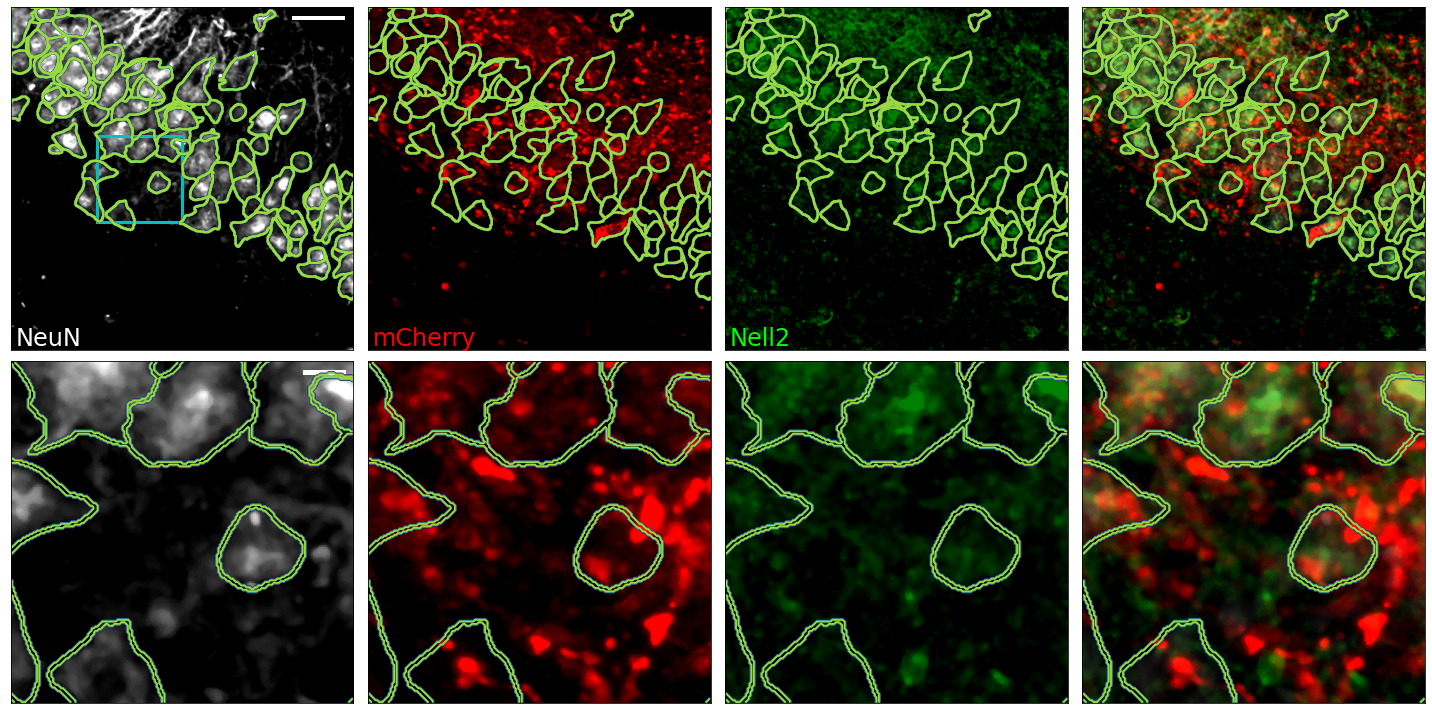

images/Nell2_08-04-22_S002_CA3_40X_2XZoom_1.oir
14  of  63


(800, 800)


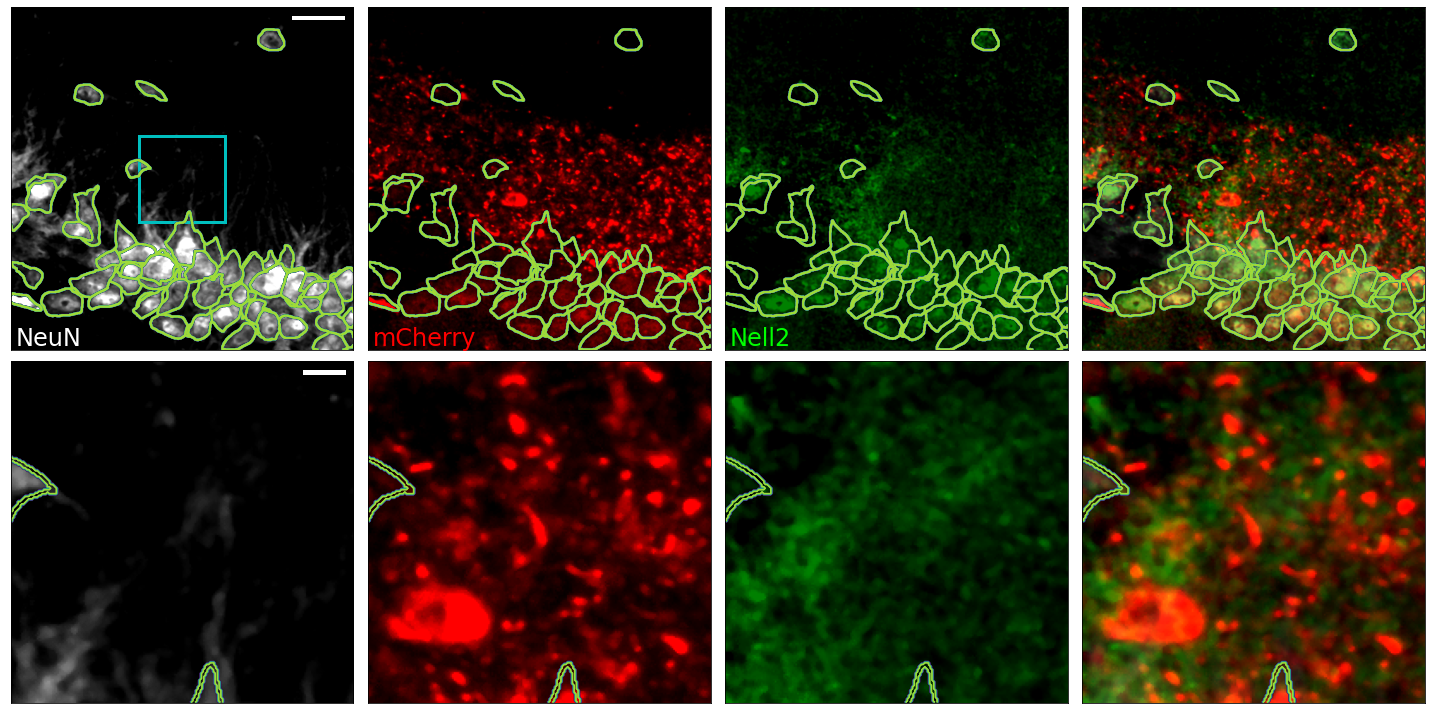

images/Nell2_08-09-22_CA3_40X_2XZoom_1.oir
2  of  77


(800, 800)


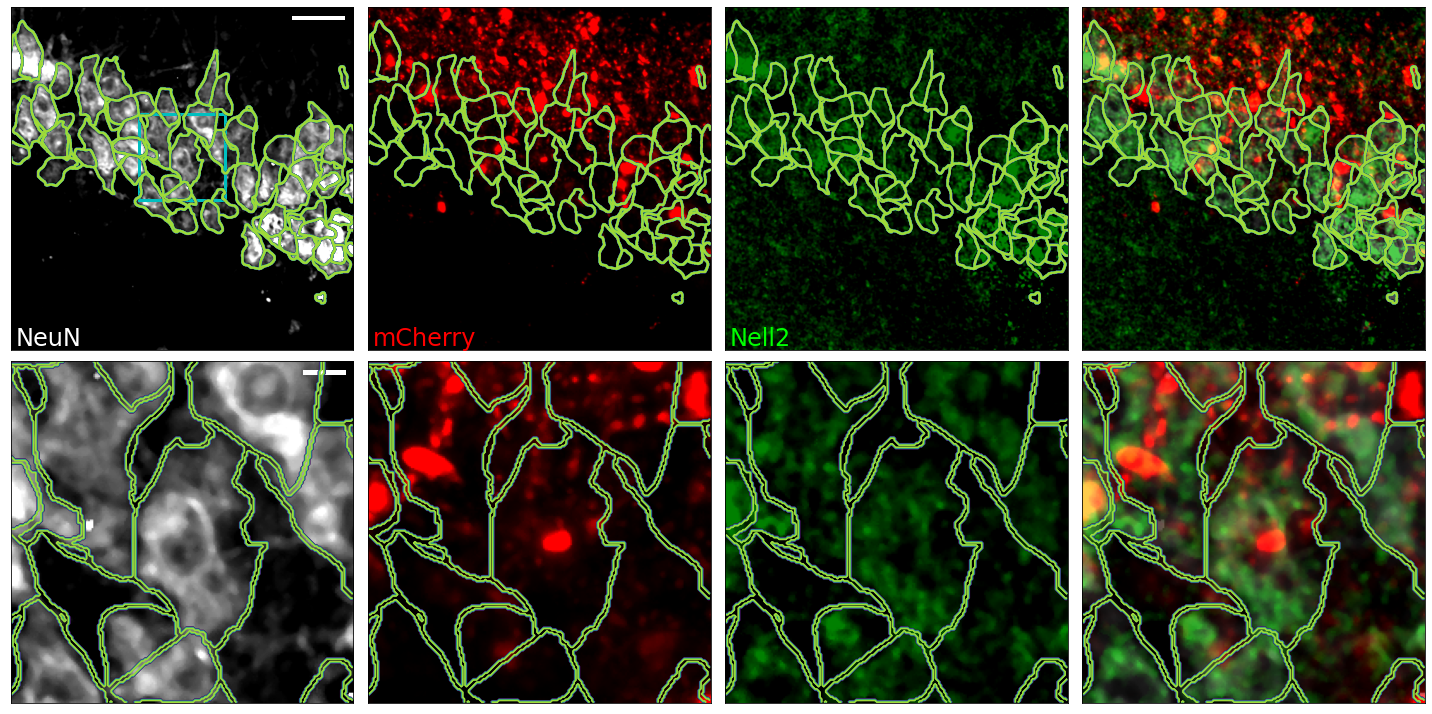

images/Nell2_08-10-22_CA3_40X_2XZoom_1.oir
20  of  48


(800, 800)


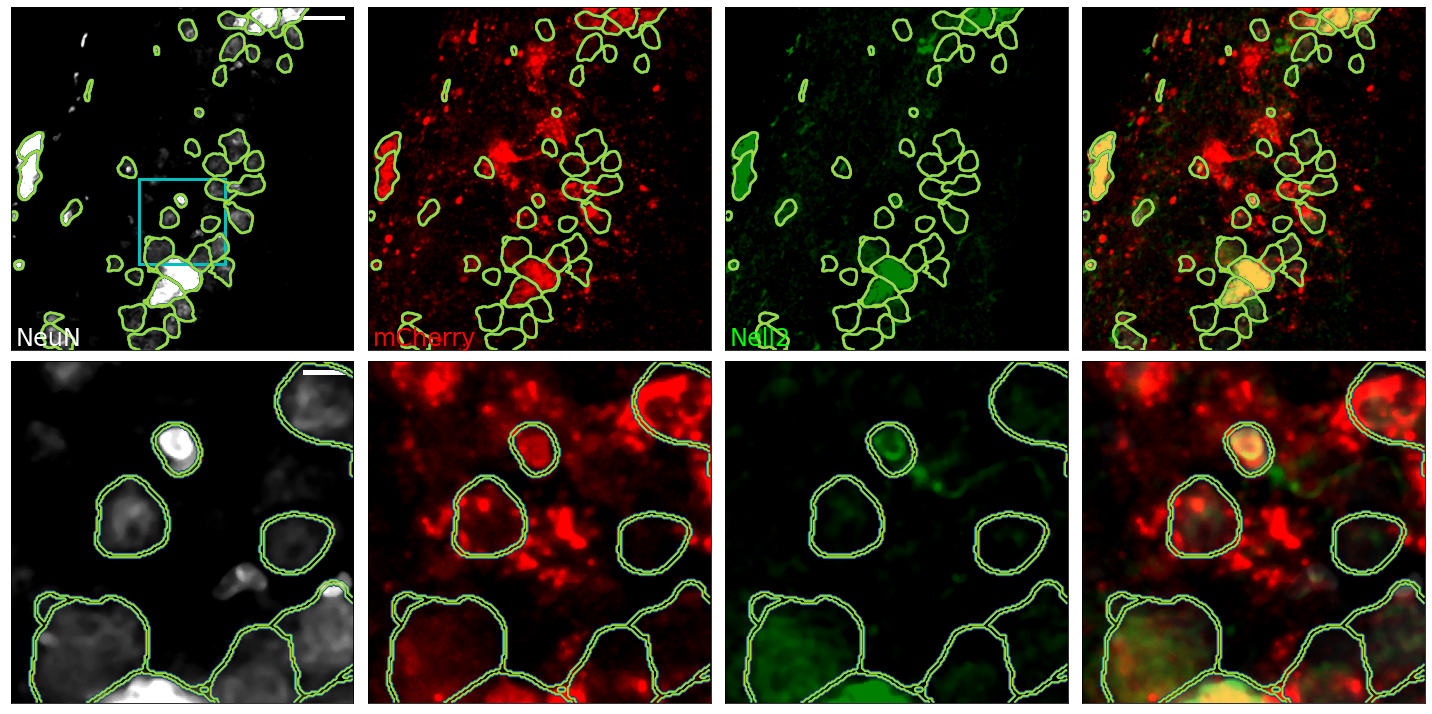

In [5]:

image_results_list[0]['sample_xy'] = [200,400,300,500]
image_results_list[1]['sample_xy'] = [300,500,300,500]
image_results_list[2]['sample_xy'] = [300,500,250,450]
image_results_list[3]['sample_xy'] = [300,500,400,600]
# image_results_list[4]['sample_xy'] = [0,200,500,700]
# image_results_list[5]['sample_xy'] = [0,200,500,700]

for f in image_results_list:
    print(f['image_name'])
    print(np.sum(f['cell_df']['Pos']), ' of ', len(f['cell_df']))
    plot_sample(f,min=0,max=6,zmax=True,inset_xy=f['sample_xy'],mask=f['exp_masks']) # 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: RuntimeWarning: divide by zero encountered in long_scalars


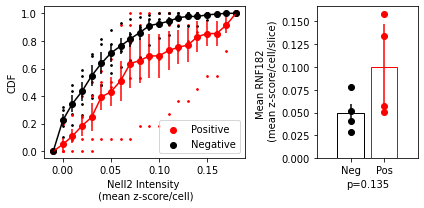

In [13]:
import scipy.stats as stats

count_pos_list=[]
count_neg_list=[]
neg_cell_means=[]
pos_cell_means=[]
cumul = True
new_t = 1
for f in image_results_list:

    f['results'],f['cell_df'] = calc_odd(f['cell_df'],new_t)
    bins = np.arange(-.01,.2,.01)
    count_neg, bin_neg = np.histogram(f['cell_df']['target_norm_NEG'],bins, density=True)
    if cumul: count_neg = np.cumsum(count_neg)*(bin_neg[1]-bin_neg[0])

    count_pos, bin_pos = np.histogram(f['cell_df']['target_norm_POS'],bins, density=True)
    if cumul: count_pos = np.cumsum(count_pos)*(bin_pos[1]-bin_pos[0])
    

    count_pos_list.append(count_pos)
    count_neg_list.append(count_neg)
    pos_cell_means.append(np.mean(f['cell_df']['target_norm_POS']))
    neg_cell_means.append(np.mean(f['cell_df']['target_norm_NEG']))

fig,ax = plt.subplots(1,2,figsize=[6,3], gridspec_kw={'width_ratios':[2, 1]})
pos_counts = np.stack(count_pos_list)
n = pos_counts.shape[0]
pos_sem = np.nanstd(pos_counts,axis=0)/np.sqrt(pos_counts.shape[0])
ax[0].scatter(bin_neg[:-1],np.nanmean(pos_counts,axis=0),color='r',label='Positive')
ax[0].errorbar(bin_neg[:-1],np.nanmean(pos_counts,axis=0),yerr=pos_sem,color='r')

size = 3
for i in range(len(count_pos_list)):
    ax[0].scatter(bin_neg[:-1],count_pos_list[i],s= size,color='r')
    ax[0].scatter(bin_neg[:-1],count_neg_list[i],s= size,color='k')

neg_counts = np.stack(count_neg_list)
neg_sem = np.nanstd(neg_counts,axis=0)/np.sqrt(neg_counts.shape[0])
ax[0].scatter(bin_neg[:-1],np.nanmean(neg_counts,axis=0),color='k',label='Negative')
ax[0].errorbar(bin_neg[:-1],np.nanmean(neg_counts,axis=0),yerr=neg_sem,color='k')
ax[0].legend()
ax[0].set_xlabel('Nell2 Intensity \n (mean z-score/cell)')
ax[0].set_ylabel('CDF')
fig.savefig('CDF.jpg')


neg_cell_means=np.array(neg_cell_means)
neg_mean_mean=np.mean(neg_cell_means)
neg_sem_mean=np.std(neg_cell_means)/np.sqrt(neg_cell_means.size)

pos_cell_means=np.array(pos_cell_means)
pos_mean_mean=np.mean(pos_cell_means)
pos_sem_mean=np.std(pos_cell_means)/np.sqrt(pos_mean_mean.size)


ax[1].scatter(np.zeros_like(neg_cell_means), neg_cell_means,c='k')
ax[1].scatter(np.ones_like(pos_cell_means),pos_cell_means,c='r')
ax[1].set_xticks([0,1])
ax[1].set_xlim([-1,2])
ax[1].set_xticklabels(['Neg','Pos'])
ax[1].bar(0,neg_mean_mean,yerr=neg_sem_mean,edgecolor='k',fill=False,ecolor='k')
ax[1].bar(1,pos_mean_mean,yerr=pos_sem_mean,edgecolor='r',fill=False,ecolor='r')
ax[1].set_ylabel('Mean RNF182 \n (mean z-score/cell/slice)')
_,pval = stats.ttest_ind(a=pos_cell_means, b=neg_cell_means, equal_var=True)
ax[1].set_xlabel(f'p={pval:.3f}')
# ax[1].bar([0,1],[np.mean(neg_cell_means),np.mean(neg_cell_means)])
plt.tight_layout()
fig.savefig('Nell2 Intensity.png')



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: RuntimeWarning: divide by zero encountered in long_scalars


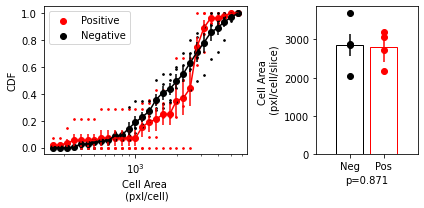

In [14]:
count_pos_list=[]
count_neg_list=[]
neg_cell_means=[]
pos_cell_means=[]
cumul = True
new_t = 1
for f in image_results_list:

    f['results'],f['cell_df'] = calc_odd(f['cell_df'],new_t)

    start=2.4
    step=.05
    stop=3.8+step    
    bins = np.power(10,np.arange(start,stop,step))
    bin_wid = np.diff(bins[:-1],prepend=10**(start-step))

    neg_vals = f['cell_df']['cross_area_NEG'][np.logical_not(f['cell_df']['is_edge'])]
    count_neg, bin_neg = np.histogram(neg_vals,bins, density=False)
    if cumul: count_neg = np.cumsum(count_neg)/sum(count_neg)

    pos_vals = f['cell_df']['cross_area_POS'][np.logical_not(f['cell_df']['is_edge'])]
    count_pos, bin_pos = np.histogram(pos_vals,bins, density=False)
    if cumul: count_pos = np.cumsum(count_pos)/sum(count_pos)
    

    count_pos_list.append(count_pos)
    count_neg_list.append(count_neg)
    pos_cell_means.append(np.mean(f['cell_df']['cross_area_POS']))
    neg_cell_means.append(np.mean(f['cell_df']['cross_area_NEG']))

fig,ax = plt.subplots(1,2,figsize=[6,3], gridspec_kw={'width_ratios':[2, 1]})
pos_counts = np.stack(count_pos_list)
n = pos_counts.shape[0]
pos_sem = np.nanstd(pos_counts,axis=0)/np.sqrt(pos_counts.shape[0])
ax[0].scatter(bin_neg[:-1],np.nanmean(pos_counts,axis=0),color='r',label='Positive')
ax[0].errorbar(bin_neg[:-1],np.nanmean(pos_counts,axis=0),yerr=pos_sem,color='r')

size = 2.8
for i in range(len(count_pos_list)):
    ax[0].scatter(bin_neg[:-1],count_pos_list[i],s= size,color='r')
    ax[0].scatter(bin_neg[:-1],count_neg_list[i],s= size,color='k')

neg_counts = np.stack(count_neg_list)
neg_sem = np.nanstd(neg_counts,axis=0)/np.sqrt(neg_counts.shape[0])
ax[0].scatter(bin_neg[:-1],np.nanmean(neg_counts,axis=0),color='k',label='Negative')
ax[0].errorbar(bin_neg[:-1],np.nanmean(neg_counts,axis=0),yerr=neg_sem,color='k')
ax[0].legend()
ax[0].set_xlabel('Cell Area \n (pxl/cell)')
ax[0].set_xscale('log')
ax[0].set_ylabel('CDF')
fig.savefig('CDF.jpg')


neg_cell_means=np.array(neg_cell_means)
neg_mean_mean=np.mean(neg_cell_means)
neg_sem_mean=np.std(neg_cell_means)/np.sqrt(neg_cell_means.size)

pos_cell_means=np.array(pos_cell_means)
pos_mean_mean=np.mean(pos_cell_means)
pos_sem_mean=np.std(pos_cell_means)/np.sqrt(pos_mean_mean.size)


ax[1].scatter(np.zeros_like(neg_cell_means), neg_cell_means,c='k')
ax[1].scatter(np.ones_like(pos_cell_means),pos_cell_means,c='r')
ax[1].set_xticks([0,1])
ax[1].set_xlim([-1,2])
ax[1].set_xticklabels(['Neg','Pos'])
ax[1].bar(0,neg_mean_mean,yerr=neg_sem_mean,edgecolor='k',fill=False,ecolor='k')
ax[1].bar(1,pos_mean_mean,yerr=pos_sem_mean,edgecolor='r',fill=False,ecolor='r')
_,pval = stats.ttest_ind(a=pos_cell_means, b=neg_cell_means, equal_var=True)
ax[1].set_xlabel(f'p={pval:.3f}')
ax[1].set_ylabel('Cell Area \n (pxl/cell/slice)')
plt.tight_layout()
fig.savefig('Nell2 Area.png')

In [8]:
for f in image_results_list:
    abrv_name = os.path.basename( f['image_name']).split('.')[0]
    f['cell_df'].to_csv( abrv_name+'Cell_Stats.csv')

In [9]:
def merge_rgbz(image):
    merge_list=[]
    for zi in range(image.shape[1]):
        w_sig = image[2,zi,:,:]
        w_sig = w_sig+np.percentile(w_sig.flatten(),.1)
        w_sig = w_sig/np.percentile(w_sig.flatten(),99.9)
        w_chan = np.stack( [w_sig for i in range(3)] ,axis=-1)
        r_sig = image[1,zi,:,:]
        r_sig = r_sig+np.percentile(r_sig.flatten(),.0)
        r_sig = r_sig/np.percentile(r_sig.flatten(),100)
        r_chan = np.stack( [r_sig, np.zeros_like(r_sig), np.zeros_like(r_sig)],axis=-1)
        g_sig =image[0,zi,:,:]
        g_sig = g_sig-(np.percentile(g_sig.flatten(),0)*2)
        g_sig = g_sig/(np.percentile(g_sig.flatten(),100)*1)
        g_chan = np.stack( [ np.zeros_like(g_sig), g_sig, np.zeros_like(g_sig)],axis=-1)
        gain = 2
        merge_zi = w_chan + r_chan + g_chan
        merge_list.append(merge_zi)
    merge = np.stack(merge_list)
    return merge

In [10]:




# # def score_image(image,chan_dim,cell_chan):



# image_name = file_list[0]

# ######################
# #####################

# image = read_image(image_name)
# if image.shape[chan_dim]==4:
#     image = combine_dapi_neun( image, chan_dim, ch_ind=[0,3], keep_ch=3,scalar = 0 )
# image_znorm, image_r,chan_dim,z_dim = norm_channels(image,chan_dim,z_dim,)
# diameter = 40
# exp_dist = 5
# masks, exp_masks = mask_image_cellpose(image_r[:,:,:,:],cell_chan,diameter,exp_dist)
# fov_dict = {'image_name':image_name,'raw_image':image,'image_znorm':image_znorm,'masks':masks,'exp_masks':exp_masks}
# plot_sample(fov_dict,title=fov_dict['image_name'],zi=4,mask=masks) # inset_xy =  [150,350,0,200]


# cell_df = quant_cells(image_znorm, image_r, exp_masks,chan_dim)
# results,cell_df = calc_odd(cell_df,t)
# cur_image_name= os.path.basename(image_name).split('.')[0]
# potential_targets = ['MDGA2','Nell2','RNF182']
# target_name = [t for t in potential_targets if t in cur_image_name][0]
# cell_df.to_csv( cur_image_name+'Cell_Stats.csv')


# fov_dict = {'image_name':image_name,
#             'raw_image':image,
#             'image_r':image_r,
#             'image_znorm':image_znorm,
#             'masks':masks,
#             'exp_masks':exp_masks,
#             'cell_df':cell_df,
#             'results':results,
#             }


# # # daims=np.arange(10,80,10)
# # # mask_dict = {}
# # # for d in daims:
# # #     masks, _ = mask_image_cellpose(image_r,cell_chan,diameter=d,exp_dist=0)
# # #     mask_dict[d]=masks

# # # print(mask_dict.keys())


# # def display_cells(fov_dict,n=10):
# #     # plot_sample(fov_dict,mask=fov_dict['masks'])

# #     cell_df = fov_dict['cell_df']
# #     pos_list = cell_df.index[cell_df['Pos']].tolist()
# #     pos_list = [int(i) for i in pos_list]
# #     pos_list_trunc = pos_list[:n+1]
# #     print(pos_list_trunc)

# #     mask = fov_dict['exp_masks']
# #     cell_id=1
# #     # for cell_id in pos_list_trunc:
# #     wher = np.where(mask==cell_id)
# #     print(np.where(mask==cell_id))
# #     top_left = [np.min(wher[1]), np.min(wher[2])]
# #     print(top_left)

    
# # display_cells(v)

NEG


/usr/local/lib/python3.7/dist-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/usr/local/lib/python3.7/dist-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: No contour levels were found within the data range.
/usr/local/lib/python3.7/dist-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/usr/local/lib/python3.7/dist-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/usr/local/lib/python3.7/dist-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/usr/local/lib/python3.7/dist-packages/numpy/lib/histograms.py:906: RuntimeWarni

POS


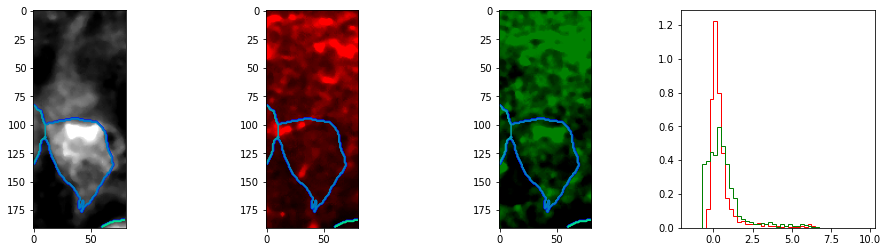

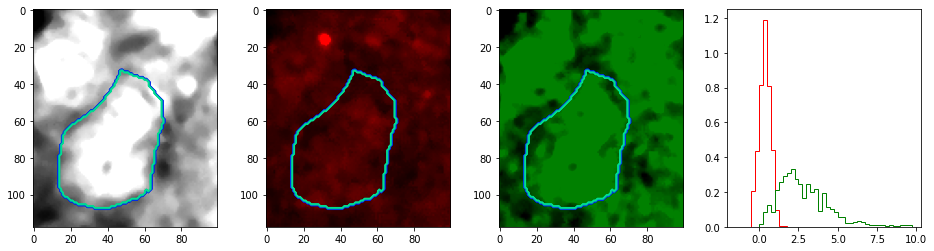

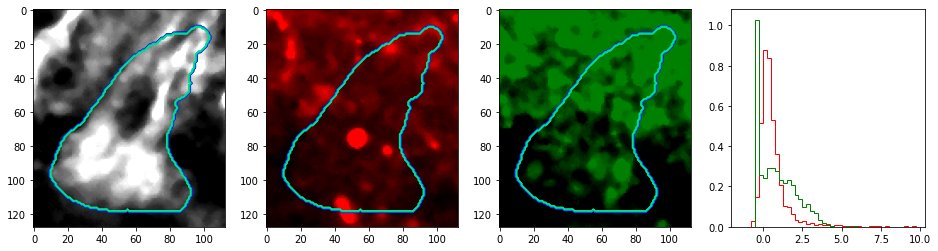

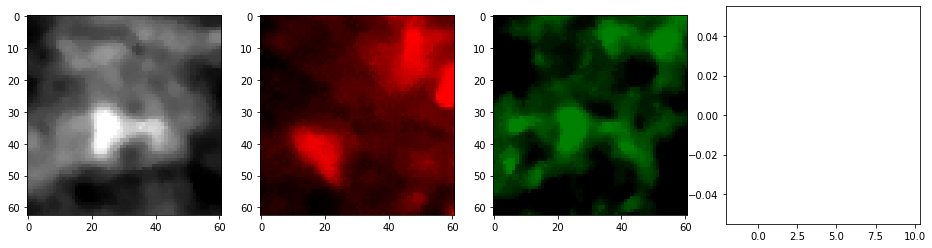

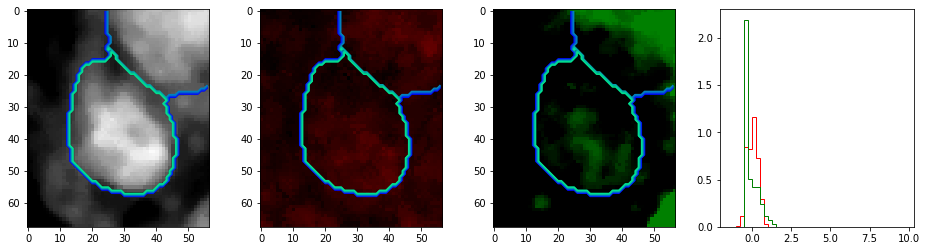

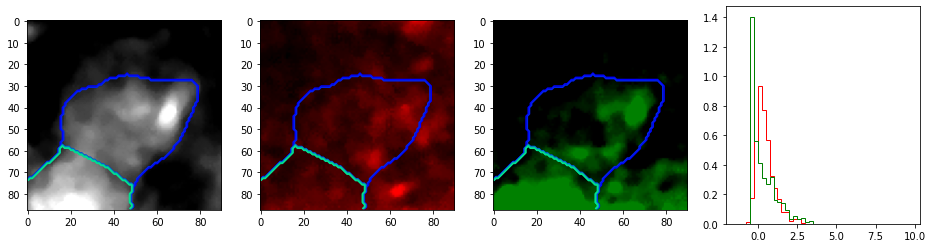

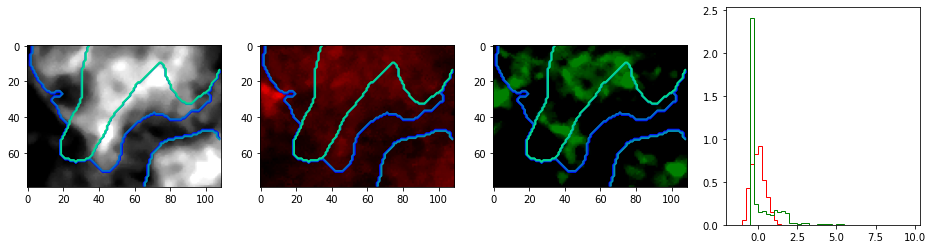

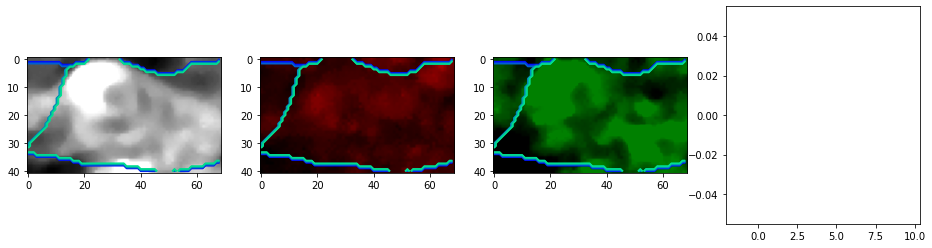

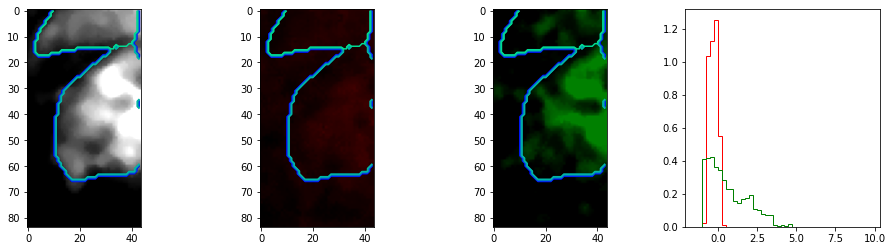

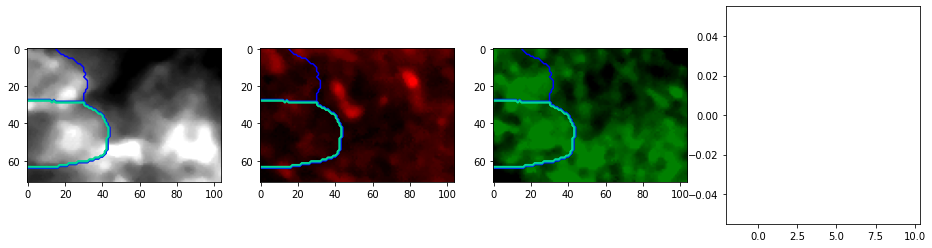

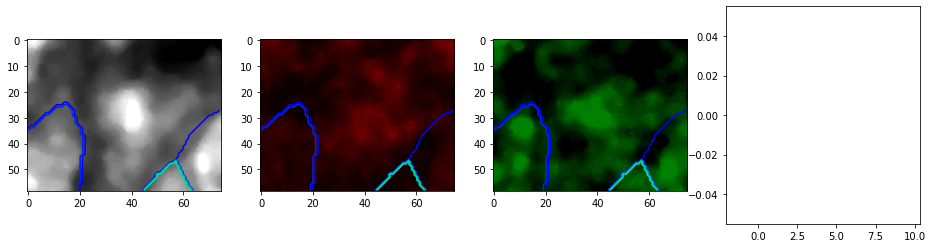

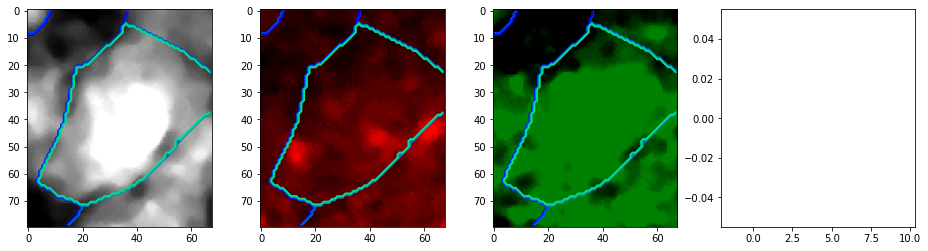

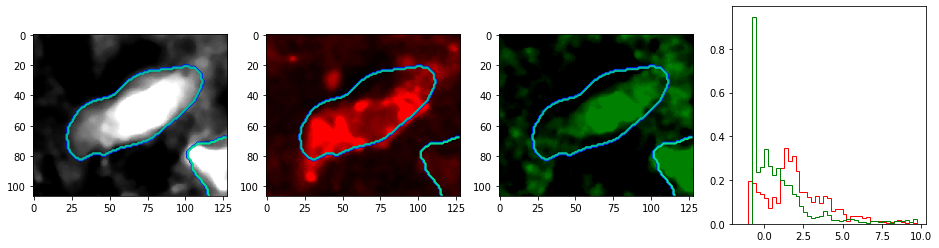

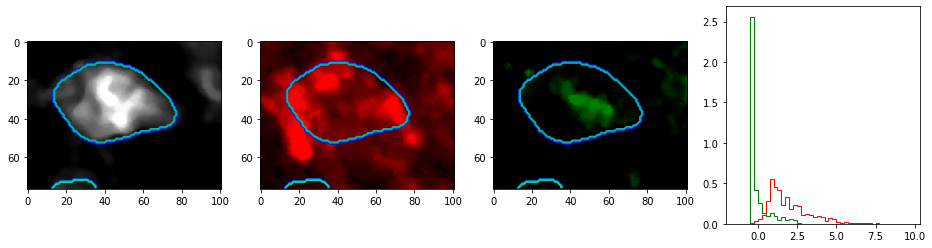

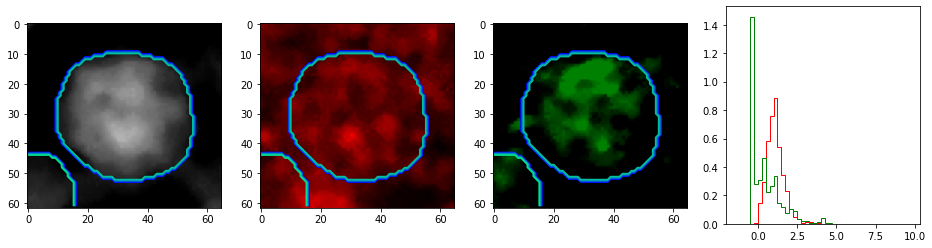

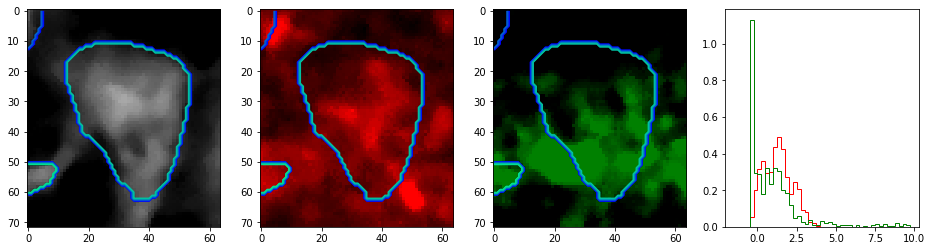

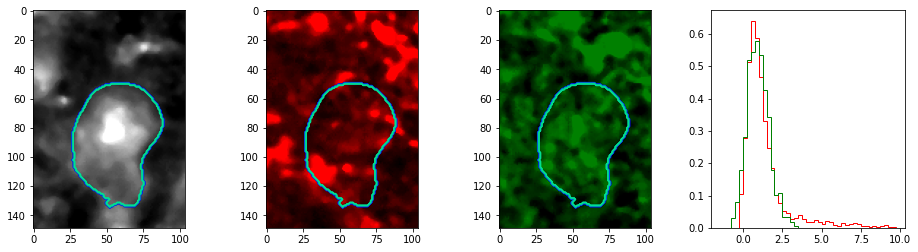

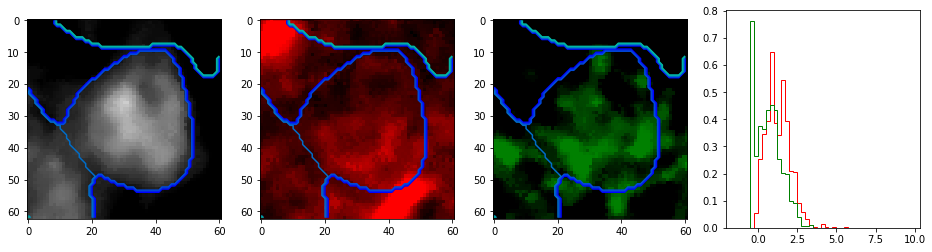

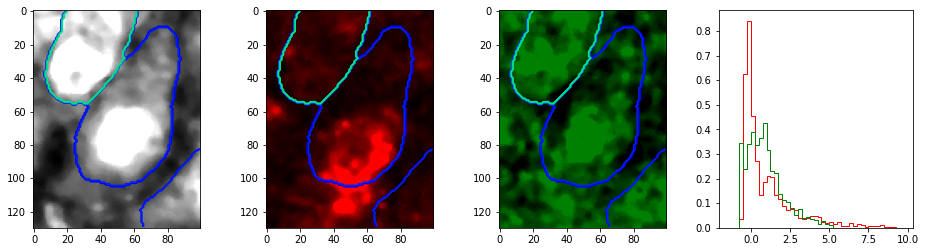

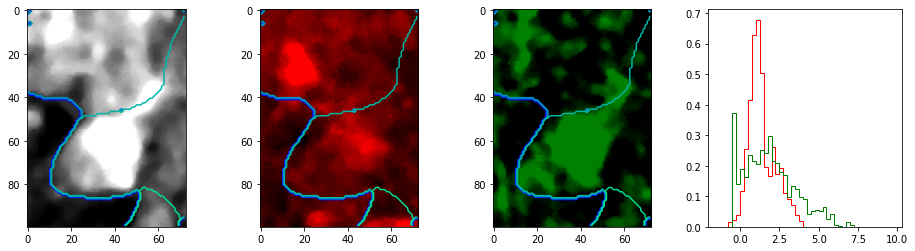

In [11]:
def display_cells(fov_dict,n=10,pos=True,buffer=10):
    # plot_sample(fov_dict,mask=fov_dict['masks'])

    cell_df = fov_dict['cell_df']
    is_pos = cell_df['Pos']
    if pos: to_use = is_pos
    else: to_use = np.logical_not( is_pos)
    cell_list = cell_df.index[to_use].tolist()
    cell_list = [int(i) for i in cell_list]
    # cell_list_trunc = cell_list[:n]
    n = np.min([n,len(cell_list)])
    cell_list_trunc = random.sample(cell_list,n)


    mask = fov_dict['exp_masks']
    [max_x, max_y] = mask.shape[-2:]
    
    for cell_id in cell_list_trunc:
        wher = np.where(mask==cell_id)
        top_left = [np.min(wher[1]), np.min(wher[2])]
        bot_right = [np.max(wher[1]), np.max(wher[2])]
        zr = list(set(wher[0]))
        x1, y1 = top_left
        x2, y2 = bot_right
        x1 = np.max([0,x1-buffer])
        y1 = np.max([0,y1-buffer])
        x2 = np.min([max_x,x2+buffer])
        y2 = np.min([max_y,y2+buffer])
        sub_im = fov_dict['image_znorm'][:,zr,x1:x2,y1:y2]
        sub_im_zstk = np.sum(sub_im,axis=1)



        fig, axs = plt.subplots(1,4,figsize=(16,4))
        zi = int(np.median(zr))
        # merge = merge_rgbz(fov_dict['image_znorm'])
        axs[0].imshow(fov_dict['image_znorm'][2,zi,x1:x2,y1:y2],cmap='gray',vmax=3)
        cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black","red"])
        axs[1].imshow(fov_dict['image_znorm'][1,zi,x1:x2,y1:y2],cmap=cmap, vmax=4)
        cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black","green"])
        axs[2].imshow(fov_dict['image_znorm'][0,zi,x1:x2,y1:y2],cmap=cmap,vmax=2)
        
        
        # cell_quant
        bins=np.arange(-1.5,10,.25)
        vals = fov_dict['image_znorm'][:,zi,:,:]
        r_vals = vals[1,:,:]
        r_vals_select = r_vals[mask[zi,:,:]==cell_id]
        axs[3].hist(r_vals_select.flatten(), bins=bins,color='r',histtype='step',density=True)
        g_vals = vals[0,:,:]
        g_vals_select = g_vals[mask[zi,:,:]==cell_id]
        axs[3].hist(g_vals_select.flatten(), bins=bins,color='g',histtype='step',density=True)

        # axs[3].imshow(merge[zi,x1:x2,y1:y2,:])

        mask_edge = skimage.filters.sobel(mask[zi,x1:x2,y1:y2]>0)

        for a in axs[:-1]:
            a.contour(mask[zi,x1:x2,y1:y2],cmap='winter')
            # a.contour(mask_edge,levels=[1,2],cmap='winter')

    sb_x = (x2-x1)*.975
    sb_y = (y2-y1)*.025
    # pxl_per_um
    # small_scale_bar = matplotlib.patches.Rectangle([sb_x,sb_y],   -5*pxl_per_um , 3, alpha=1, facecolor='w',edgecolor='w',linewidth=0)
    # axs[4].add_patch(small_scale_bar)

import random

fov = image_results_list[0]
n = 10
print('NEG')
display_cells(fov,n=n,pos=False)
print('POS')
display_cells(fov,n=n,pos=True)

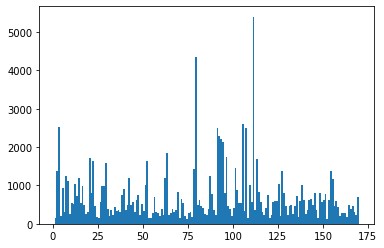

size  cross_area is_edge  mean_target  raw_mean_target  \
cell_id                                                             
1.0      1638.0       596.0    True     0.277518         0.023694   
2.0      1635.0       672.0   False     1.803382         0.100321   
3.0      1197.0       447.0   False     0.503756         0.053403   
4.0      1850.0       471.0   False     1.150584         0.085065   
5.0      1441.0       680.0   False     0.019652         0.035111   
6.0      4353.0      1572.0   False     1.956858         0.127100   
7.0      1249.0      1249.0   False     1.823735         0.123543   
8.0      2200.0      1086.0   False     1.500206         0.082946   
9.0      2123.0       840.0   False     1.241392         0.068380   
10.0     1754.0       556.0   False     2.979694         0.137806   
11.0     1021.0       464.0   False    -0.596756         0.001129   
12.0     5403.0      1523.0   False     0.680217         0.052357   
13.0     1697.0       669.0   False    -0.350302         0.013293   
14.0     1023.0       682.0   False    -0.433770         0.000732   
15.0     1383.0       836.0   False    -0.446240         0.000000   
16.0     1173.0       674.0   False     1.324692         0.064457   

         mean_mCherry  raw_mean_mCherry  mean_NeuN  raw_mean_NeuN  
cell_id                                                            
1.0          4.791439          0.055827   0.297898       0.041210  
2.0          2.985817          0.052118   2.123235       0.149803  
3.0          2.345315          0.049278   0.342231       0.050280  
4.0          2.379243          0.051947   0.669079       0.064489  
5.0          1.706739          0.043821   0.745940       0.071331  
6.0          2.070913          0.049762   3.407175       0.209311  
7.0          3.299612          0.069811   2.963061       0.197451  
8.0          2.132914          0.047210   0.778040       0.037759  
9.0          1.383309          0.034916   0.754776       0.026729  
10.0         4.164748          0.077174   1.257839       0.044036  
11.0        -0.000902          0.014871   0.180604       0.023105  
12.0         2.543136          0.053173   2.582523       0.099709  
13.0         1.259543          0.034915   1.633779       0.075463  
14.0         1.995300          0.041986   0.234906       0.016435  
15.0         0.994056          0.026939   0.277767       0.016593  
16.0         0.217986          0.015379   0.006066       0.009833

(800, 800)


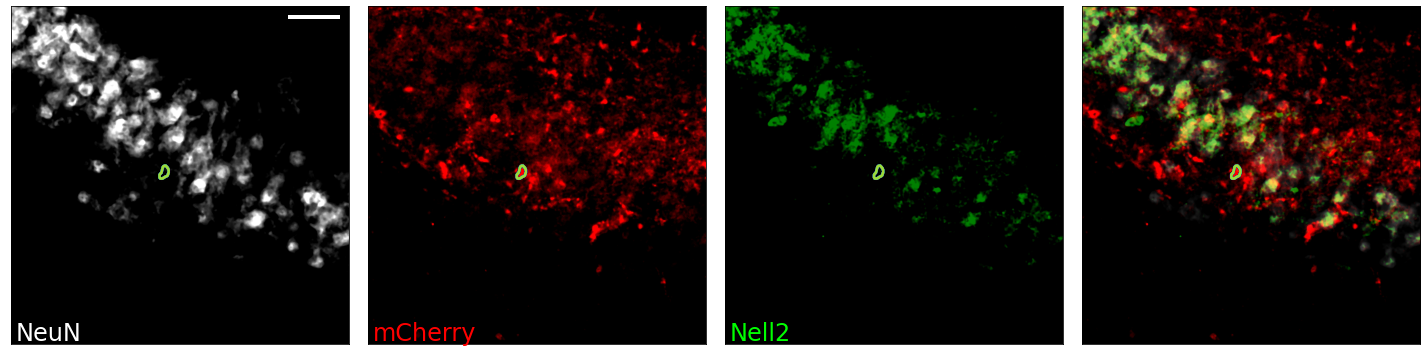

In [12]:
############## Get red masks
image_r = fov['image_r']
exp_dist = 0
red_masks, red_exp_masks = mask_image_cellpose(image_r,1,diameter,exp_dist)
bins=np.arange(1,np.max(red_exp_masks.flatten()))
min_size = 1000
plt.hist(red_exp_masks.flatten(),bins=bins)
plt.show()
counts,_ = np.histogram(red_exp_masks.flatten(),bins=bins)
to_keep = [i+1 for i in range(len(counts)) if counts[i]>min_size]

red_exp_masks_c = np.zeros_like(red_exp_masks)
for ci in range(len(to_keep)):
    c = to_keep[ci]
    red_exp_masks_c[red_exp_masks==c] = ci
red_exp_masks = red_exp_masks_c

red_cell_df = quant_cells(fov['image_znorm'], image_r, red_exp_masks,chan_dim=0)
to_keep = np.where(red_cell_df['mean_NeuN']>0)[0]+1
red_exp_masks_c = np.zeros_like(red_exp_masks)
for ci in range(len(to_keep)):
    c = to_keep[ci]
    red_exp_masks_c[red_exp_masks==c] = ci
red_exp_masks = red_exp_masks_c
red_cell_df = quant_cells(fov['image_znorm'], image_r, red_exp_masks,chan_dim=0)
display(red_cell_df)


# # red_cell_df.columns

plot_sample(fov,mask=red_exp_masks)